# Exercise IV: Logistic Regression

> In statistics, the logistic model (or logit model) is used to model the probability of a certain class or event existing such as pass/fail, win/lose, alive/dead or healthy/sick. This can be extended to model several classes of events such as determining whether an image contains a cat, dog, lion, etc. Each object being detected in the image would be assigned a probability between 0 and 1, with a sum of one. [*Wikipedia*](https://en.wikipedia.org/wiki/Logistic_regression)

In this exercise we will reproduce the bank defaults example used in chapter IV of the ISLR, as adapted from the [ISLR-python](https://github.com/JWarmenhoven/ISLR-python) repository.

We will use this example to illustrate the concept of classification, where we aim to predict whether an individual will **default** on his or her credit card payment (i.e, fail to pay at least the minimal amount in a given number of days).

## Setup

In [1]:
import warnings
warnings.simplefilter("ignore")

In [2]:
import pandas as pd

URL = "https://github.com/JWarmenhoven/ISLR-python/raw/master/Notebooks/Data/Default.xlsx"
df = pd.read_excel(URL, index_col=0, true_values=["Yes"], false_values=["No"])

In [3]:
def color_booleans(value: bool) -> str:
    color = "green" if value else "red"
    return f"color: {color}"

BOOLEAN_COLUMNS = ["default", "student"]

df.sample(15).style.text_gradient(cmap="Blues").applymap(color_booleans, subset=BOOLEAN_COLUMNS)

,default,student,balance,income
5900,False,True,1090.925059,18935.818220
8368,False,False,1449.135708,40495.472180
2303,False,True,1000.621768,17223.637965
7674,False,True,1127.435955,23495.565517
1693,False,False,640.063894,52413.858970
8934,False,False,821.853293,35358.392736
6806,False,True,735.578365,13976.685911
5610,False,False,92.900089,43955.881366
4990,False,False,0.000000,38686.675290
2385,False,False,890.213023,43643.582395


There seem to be some imbalance in the number of "default" observations - it seems like most of the individuals in this dataset do not default on their credit card payment.

We will address this issue later on.

In [4]:
display(df["default"].value_counts(normalize=True).to_frame().style.format("{:.2%}").set_caption("Default Rate"))

,proportion
default,
False,96.67%
True,3.33%


### Feature Scaling

In [5]:
import numpy as np
from sklearn.preprocessing import StandardScaler

numeric_features = df.select_dtypes(include="number")
scaler = StandardScaler()
df.loc[:, numeric_features.columns] = scaler.fit_transform(df.loc[:, numeric_features.columns])

## Raw inspection

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   default  10000 non-null  bool   
 1   student  10000 non-null  bool   
 2   balance  10000 non-null  float64
 3   income   10000 non-null  float64
dtypes: bool(2), float64(2)
memory usage: 253.9 KB


In [7]:
pd.set_option('float_format', '{:g}'.format)
df.describe()

,balance,income
count,10000,10000
mean,-1.25056e-16,-1.93623e-16
std,1.00005,1.00005
min,-1.72708,-2.45539
25%,-0.731136,-0.913058
50%,-0.0242674,0.0776593
75%,0.684184,0.771653
max,3.76056,3.0022


### Scatter plot

Visualize some interesting numeric features (balance & income) in relation to our target.

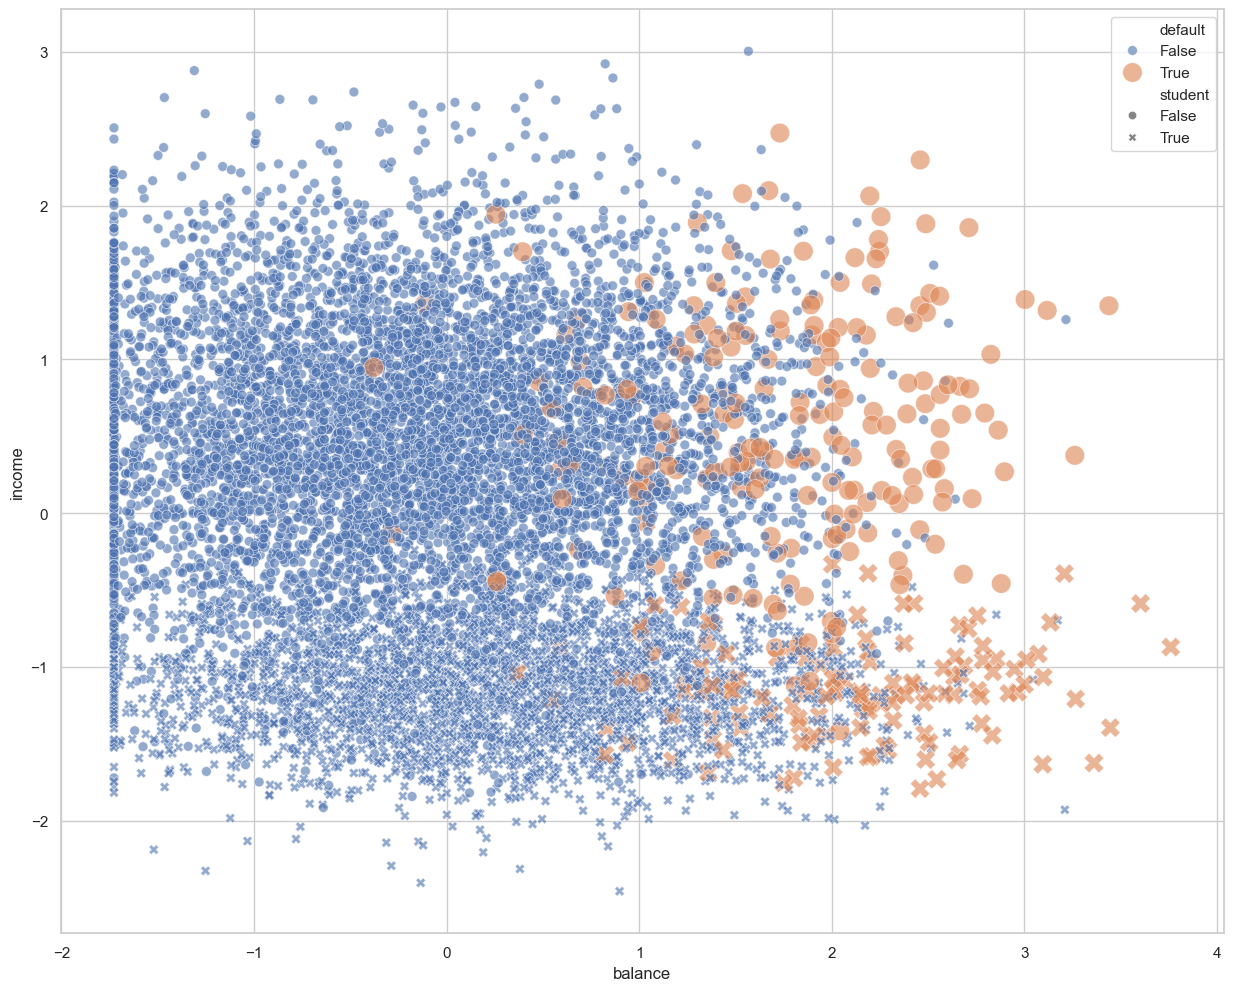

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

fix, ax = plt.subplots(figsize=(15, 12))
_ = sns.scatterplot(x="balance",
                    y="income",
                    hue="default",
                    style="student",
                    size="default",
                    sizes={
                        True: 200,
                        False: 50
                    },
                    alpha=0.6,
                    ax=ax,
                    data=df)

### Violin plot

And plot the distributions of these features under each level of the categorical features.

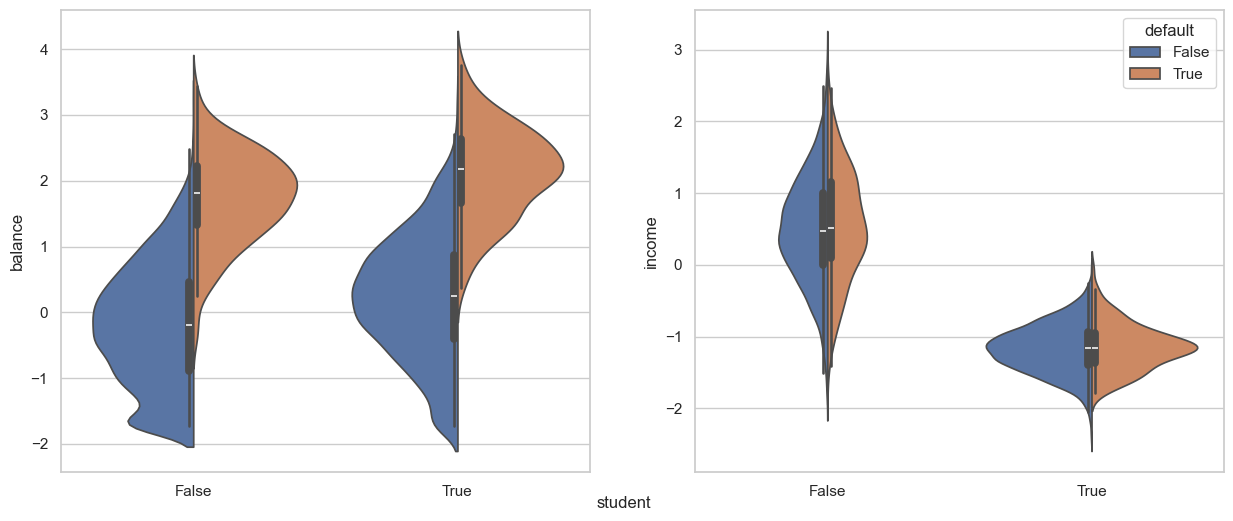

In [9]:
# Create a new figure with two horizontal subplots 
fig, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plot balance
sns.violinplot(x="student", y="balance", hue="default", split=True, legend=False, ax=ax[0], data=df)
ax[0].set_xlabel('')

# Plot income
sns.violinplot(x="student", y="income", hue="default", split=True, ax=ax[1], data=df)
ax[1].set_xlabel('')

# Add common label
_ = fig.text(0.5, 0.05, "student", ha='center')

## Train/Test Split

In [10]:
from sklearn.model_selection import train_test_split 

FEATURE_NAMES = ["balance", "income", "student"]
TARGET_NAME = "default"
X = df[FEATURE_NAMES]
y = df[TARGET_NAME].values

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=0,
                                                    test_size=0.2)

## Model Creation

### `sklearn`

In [11]:
from sklearn.linear_model import LogisticRegression

sk_model = LogisticRegression(random_state=0, penalty=None, solver="newton-cg")
_ = sk_model.fit(X_train, y_train)

### `statsmodels`

In [12]:
import statsmodels.api as sm

# statsmodels requires booelean values to be converted to integers.
df["student"] = df["student"].astype(int)
df["default"] = df["default"].astype(int)

# R-style model formulation.
sm_model = sm.Logit.from_formula('default ~ balance + income + student', data=df)

## Model Application

### `sklearn`

We can predict the **probability** estimates of each target class (in our case `True` or `False`) using the [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) class's [`predict_proba()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba) method:

In [13]:
default_probability = sk_model.predict_proba(X_test)

Note that when predicting probabilities, we get an array of shape $n_{samples} \text{ X } n_{classes}$, representing the probability of each sample to belong to each class of the target variable.

Or, we could directly return the predictions based on the maximal probabilities:

In [14]:
predictions = sk_model.predict(X_test)

# Manually returning the index of the maximal value
predictions_manual = default_probability.argmax(axis=1)

np.array_equal(predictions, predictions_manual)

True

### `statsmodels`

In [15]:
sm_estimation = sm_model.fit()

Optimization terminated successfully.
         Current function value: 0.078577
         Iterations 10


## Model Evaluation

### `sklearn`

In [16]:
print(f"Intercept: {sk_model.intercept_}")
print(f"Coefficients: {sk_model.coef_}")

Intercept: [-5.92939642]
Coefficients: [[ 2.71890021 -0.02275812 -0.61743409]]


#### Confusion Matrix

##### Calculation

In [17]:
from sklearn.metrics import confusion_matrix

confusion_matrix_ = confusion_matrix(y_test, predictions)
print(confusion_matrix_)

[[1920    6]
 [  51   23]]


##### Visualization

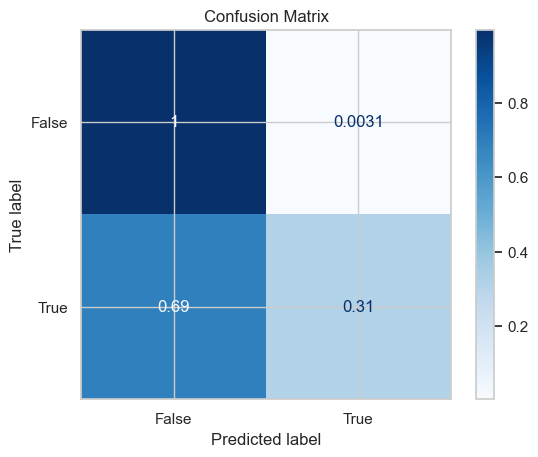

In [18]:
# visualizing the confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_estimator(
    sk_model,
    X_test,
    y_test,
    display_labels=sk_model.classes_,
    cmap = plt.cm.Blues,
    normalize="true"
    )
_ = disp.ax_.set_title(f"Confusion Matrix")
# from sklearn.metrics import plot_confusion_matrix

# disp = plot_confusion_matrix(sk_model,
#                              X_test,
#                              y_test,
#                              cmap=plt.cm.Greens,
#                              normalize="true")
# _ = disp.ax_.set_title(f"Confusion Matrix")

#### Classification Report

In [19]:
from sklearn.metrics import classification_report

report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

       False       0.97      1.00      0.99      1926
        True       0.79      0.31      0.45        74

    accuracy                           0.97      2000
   macro avg       0.88      0.65      0.72      2000
weighted avg       0.97      0.97      0.97      2000



<figure>
    <center><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/350px-Precisionrecall.svg.png" alt="Precision & Recall" width="400"/></center>
    <figcaption>
        <i>
            Precision and Recall are performance metrics that allow the evaluation of a classification algorithm.
            <a href="https://en.wikipedia.org/wiki/Precision_and_recall">
                Wikipedia
            </a>
        </i>
    </figcaption>
</figure>

##### Precision

<figure>
    <center><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/26106935459abe7c266f7b1ebfa2a824b334c807" alt="Precision" width="400"/></center>
    <figcaption>
        <i>
            What proportion of positive identifications was actually correct?
            <a href="https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall#precision">
                Google Developers
            </a>
        </i>
    </figcaption>
</figure>


In [20]:
true_positive = confusion_matrix_[1, 1]
false_positive = confusion_matrix_[0, 1]

true_positive / (true_positive + false_positive)

0.7931034482758621

##### Recall (Sensitivity)

<figure>
    <center><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/4c233366865312bc99c832d1475e152c5074891b" alt="Recall" width="400"/></center>
    <figcaption>
        <i>
            What proportion of actual positives was identified correctly?
            <a href="https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall#recall">
                Google Developers
            </a>
        </i>
    </figcaption>
</figure>

In [21]:
false_negative = confusion_matrix_[1, 0]

true_positive / (true_positive + false_negative)

0.3108108108108108

##### Specificity

<figure>
    <center><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/8f2c867f0641e498ec8a59de63697a3a45d66b07" alt="Specificity" width="400"/></center>
    <figcaption>
        <i>
            What proportion of actual negatives was identified correctly?
            <a href="https://en.wikipedia.org/wiki/Sensitivity_and_specificity">
                Wikipedia
            </a>
        </i>
    </figcaption>
</figure>

In [22]:
true_negative = confusion_matrix_[0, 0]

true_negative / (true_negative + false_positive)

0.9968847352024922

##### Accuracy Score

<figure>
    <center><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/7bfe40cea126a04004b82f729cf7df1ec435fbf6" alt="Accuracy" width="400"/></center>
    <figcaption>
        <i>
            What is the proportion of correct identifications?
            <a href="https://en.wikipedia.org/wiki/Accuracy_and_precision#In_classification">
                Wikipedia
            </a>
        </i>
    </figcaption>
</figure>

In [23]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, predictions)

0.9715

or:

In [24]:
true_predictions = confusion_matrix_[0, 0] + confusion_matrix_[1, 1]
true_predictions / len(X_test)

0.9715

### `statsmodels`

#### Confusion Matrix

In [25]:
prediction_table = sm_estimation.pred_table()
prediction_table

array([[9627.,   40.],
       [ 228.,  105.]])

In [26]:
row_sums = prediction_table.sum(axis=1, keepdims=True)
prediction_table / row_sums

array([[0.99586221, 0.00413779],
       [0.68468468, 0.31531532]])

#### Regression Report
The regression report is a summary of the regression model.
It includes the coefficients, standard errors, t-values, p-values, and confidence intervals for each coefficient.

In [27]:
sm_estimation.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9996
Method:                           MLE   Df Model:                            3
Date:                Sun, 01 Dec 2024   Pseudo R-squ.:                  0.4619
Time:                        16:14:21   Log-Likelihood:                -785.77
converged:                       True   LL-Null:                       -1460.3
Covariance Type:            nonrobust   LLR p-value:                3.257e-292
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.9752      0.194    -30.849      0.000      -6.355      -5.596
balance        2.7747      0.112     24.737      0.000       2.555       2.995
income         0.0405      0.109      0.370      0.712      -0.174       0.255
student       -0.6468      0.236     -2.738      0.006      -1.110      -0.184
==============================================================================

Possibly complete quasi-separation: A fraction 0.15 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""